In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
# Load the data
genotypes = pd.read_csv('tomatoes/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [15]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [17]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [18]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)

In [29]:
# Setup XGBoost for feature selection with cross-validation
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a K-Fold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Array to store feature importances across folds
feature_importances = np.zeros(X_train_scaled.shape[1])
cv_rmse = []

In [30]:
# Perform cross-validation
for train_index, test_index in kf.split(X_train_scaled):
    X_train_fold, X_test_fold = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Fit XGBoost model
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on fold test data and calculate RMSE
    fold_pred = xgb_model.predict(X_test_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_test_fold, fold_pred))
    cv_rmse.append(fold_rmse)
    
    # Accumulate feature importances
    feature_importances += xgb_model.feature_importances_

In [32]:
# Average feature importances over all folds
feature_importances /= kf.get_n_splits()

# Select features using a threshold (mean importance here)
mean_importance_threshold = np.mean(feature_importances)
selected_features = X_train_scaled.columns[feature_importances > mean_importance_threshold]


In [27]:
# Export selected features
selected_features.to_series().to_csv('Features_selected/selected_features_xgboost.csv', index=False)

In [22]:
# Reduce training and testing sets to selected features
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [23]:
# Train a linear regression model using selected features
regressor = LinearRegression()
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)

In [31]:
# Calculate RMSE and R-squared for evaluation
# Print the cross-validated RMSE
print("Cross-Validated RMSE: ", np.mean(cv_rmse))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse}')
print(f'Test R²: {r2}')

Cross-Validated RMSE:  2.2018239106832604
Test RMSE: 2.3354068947607325
Test R²: 0.2296820986415563


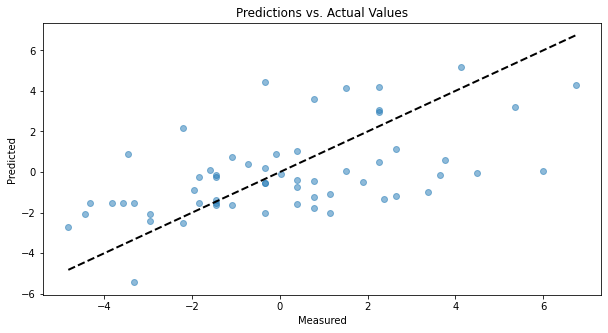

In [34]:
# Visualization of predictions vs. actual outcomes
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()
